# Welcome to the Big Data Processing Course Evaluation!

## Alexandre TONON et Audrey MAURETTE

Today, the goal is to understand how a distributed system can be useful when dealing with medium to large scale data sets.  
We'll see that Dask start to be nice as soon as the Data we need to process doesn't quite fit in memory, but also if we
need to launch several computations in parallel.

In this evaluation, you will:
- Use Dask to read and understand the several gigabytes input dataset in a interactive way,
- Preprocess the data in a distributed way: cleaning it up and adding some useful features,
- Launch some model training that can be parallelized on a big dataset,
- Reduce the dataset and train more accurate models on less Data,
- Do an hyper parameter search to find the best model on a small sample of Data.

In order to run and fill this notebook, you've got two solutions:
1. First deploy a Dask enabled Kubernetes cluster as seen before. So please use the [Kubernetes_DaskHub](https://github.com/SupaeroDataScience/DE/blob/main/notebooks/Kubernetes_Daskhub.ipynb) notebook for the steps to do it.
2. Rely on your local machine using a LocalCluster (8GiB memory, 4 cores minimum, if possible 16GiB) inside a compatible environment: dask, pandas, dask-ml, ipywidgets, scikit-learn, xgboost, lightgbm.

Once the Jupyterhub or local environement is ready, you can clone the `big-data-processing-course` repository from a Jupyterlab terminal to get this notebook, and select the default kernel.
```
git clone https://github.com/CNES/big-data-processing-course.git
cd big-data-processing-course/notebooks
```

## The Dataset

It is some statistics about NY Taxi cabs. 

See https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview, or https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data.
        
The goal of this evaluation will be to generate a model using machine learning algorithms that will predict the fare amount
of a taxi ride given the other input parameters we have.

The model will be evaluated using the Root mean squared error algorithm:  
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation.

## Try to analyze the Data using Kaggles' start-up code

As an introduction, we'll use Kaggle starters' code to get some insights on the data set and
computations we'll do and measure pandas library (non parallelized access and process) performance.

See https://www.kaggle.com/dster/nyc-taxi-fare-starter-kernel-simple-linear-model where this comes from.

This Kaggle method will set the bar to beat with our own tools. I'm sure you can do it.

#### Reading the data with pandas

We're reading less than 20% from the whole data set. Using the storage_options kwarg was mandatory for me to avoid auth issues, don't forget it when you read public data from cloud storage during this evaluation.

In [1]:
%%time
import pandas as pd
train_df =  pd.read_csv('gs://supaero/train.csv', nrows = 10_000_000, storage_options={'token': 'anon'})
train_df.dtypes

CPU times: user 27.2 s, sys: 4.47 s, total: 31.7 s
Wall time: 43.5 s


key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

#### Analysing dataset, adding some features and droping null values

Let's see if we can see some correlation between passengers count and fare amount?

In [2]:
%%time
train_df.groupby(train_df.passenger_count).fare_amount.mean()

CPU times: user 187 ms, sys: 39.1 ms, total: 227 ms
Wall time: 226 ms


passenger_count
0       9.006352
1      11.210204
2      11.824815
3      11.543991
4      11.771902
5      11.204430
6      12.149398
7      14.500000
8      80.000000
9      32.815000
34     13.300000
49      2.500000
208     9.866667
Name: fare_amount, dtype: float64

Maybe adding some features about the distance of the trip could be a good idea?

In [3]:
%%time
# 'abs_diff_longitude' 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

CPU times: user 96.7 ms, sys: 96.7 ms, total: 193 ms
Wall time: 192 ms


Are there some undefined values?

In [4]:
%%time
print(train_df.isnull().sum())

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude     65
dropoff_latitude      65
passenger_count        0
abs_diff_longitude    65
abs_diff_latitude     65
dtype: int64
CPU times: user 1.02 s, sys: 29.5 ms, total: 1.04 s
Wall time: 1.04 s


We want to get rid of them.

In [5]:
%%time
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 10000000
New size: 9999935
CPU times: user 1.79 s, sys: 327 ms, total: 2.12 s
Wall time: 2.11 s


#### Quick analyze on new features and clean outliers

CPU times: user 505 ms, sys: 91.1 ms, total: 596 ms
Wall time: 694 ms


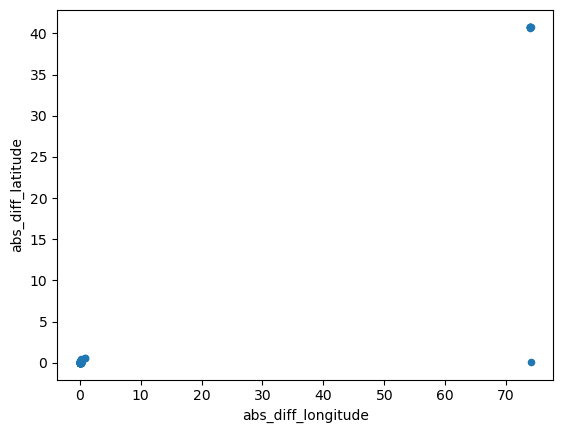

In [6]:
%%time
plot = train_df.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

70 degrees longitude seems a bit too high...

In [7]:
%%time
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df))

Old size: 9999935
New size: 9979308
CPU times: user 653 ms, sys: 284 ms, total: 937 ms
Wall time: 935 ms


#### Get training features and results

In [8]:
%%time
import numpy as np

# using the travel vector, plus a 1.0 for a constant bias term.
def get_input_matrix(df):
    return np.column_stack((df.abs_diff_longitude, df.abs_diff_latitude, np.ones(len(df))))

train_X = get_input_matrix(train_df)
train_y = np.array(train_df['fare_amount'])

print(train_X.shape)
print(train_y.shape)

(9979308, 3)
(9979308,)
CPU times: user 104 ms, sys: 93.2 ms, total: 197 ms
Wall time: 195 ms


#### Train a simple linear model using Numpy

In [9]:
%%time
# The lstsq function returns several things, and we only care about the actual weight vector w.
(w, _, _, _) = np.linalg.lstsq(train_X, train_y, rcond = None)
print(w)

[147.3292454   70.82802188   6.51937826]
CPU times: user 901 ms, sys: 622 ms, total: 1.52 s
Wall time: 790 ms


#### Make prediction on our test set and measure performance

In [10]:
test_df =  pd.read_csv('gs://supaero/test.csv', storage_options={'token': 'anon'})
test_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [11]:
add_travel_vector_features(test_df)
test_X = get_input_matrix(test_df)

In [12]:
test_y_predictions = np.matmul(test_X, w).round(decimals = 2)

In [13]:
test_y_ref = test_df.fare_amount

In [14]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y_ref, test_y_predictions, squared=False)

5.230460641047829

OK, so about 5,23$ of RMSE, this is not that bad... But we can do better.

<span style="color:#EB5E0B;font-style:italic">

### Some questions on this first Analysis

- What is the most time consuming part of the analysis (see the %%time we used in all the cells above)?
</span>

<span style="color:green">
La lecture des données est l'étape qui prend le plus de temps (~40s).
    
Ensuite c'est l'élimination des NaN avec 2,82s, car il doit parcourir et accéder aux valeurs une à une de tout le dataset ce qui prend environ 1s
</span>.


<span style="color:#EB5E0B;font-style:italic">
    
- Try to load the whole dataset with Pandas and comment what happens. Can you explain why?
</span>

In [ ]:
%%time

train_df =  pd.read_csv('gs://supaero/train.csv', storage_options={'token': 'anon'})
train_df.dtypes

<span style="color:green">
En lisant le dataset entier, le serveur crash. 

Cela s'explique par le fait que le dataset est plus lourd que la mémoire ram disponible <strong>sur le pod jupyter lab</strong> ce qui fait tout planter.
</span>

# Processing our data set using Dask

Dask will help us process all the input data set at once. It is really useful when input data is too big to fit in memory. In this case, it can stream the computation by data chunks on one computer, or distribute the computation on several computers.

This is what we'll do next!

### Start an appropriately sized Dask cluster for our analysis

We'll need a Dask cluster to pre process the data and distribute some learning, the following code starts one in our K8S infrastructure.

**If you're running this notebook on your laptop or local computer, just uncomment the 4th cell below and run it instead of the others.**

In [3]:
from dask_gateway import Gateway
gateway = Gateway()
gateway.list_clusters()

[ClusterReport<name=daskhub.c7d5ace60d854e2e9d1d3d9720095f31, status=RUNNING>]

In [4]:
# Ensure that we don't have any other cluster running
for dg_cluster in gateway.list_clusters():
    cluster = gateway.connect(dg_cluster.name)
    cluster.shutdown()

In [5]:
cluster = gateway.new_cluster(worker_cores=1, worker_memory=3.0)
cluster

In [ ]:
#from distributed import Client
#client = Client(n_workers=4, threads_per_worker=2)
#client

__Please click on the Dashboard link above, it will help you a lot!__

__Do not run the two following cells if you are using a LocalCluster/Client__

In [6]:
cluster.scale(16)

In [7]:
# Declaring a client object is mandatory to use our Dask cluster by default
client = cluster.get_client()

In [8]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/daskhub.baa869494a204ad18f410346d477b4d6/status,


### Launch some computation, what about Pi?

Just to check our cluster is working!

We'll use Dask array, a Numpy extension for this, we'll also use it later on for the Machine Learning part of this evaluation.

In [ ]:
%%time
import dask.array as da

sample = 10_000_000_000  # <- this is huge!
xxyy = da.random.uniform(-1, 1, size=(2, sample))
norm = da.linalg.norm(xxyy, axis=0)
summ = da.sum(norm <= 1)
insiders = summ.compute()
pi = 4 * insiders / sample
print("pi ~= {}".format(pi))

## Now, access the data of our BE using Dask

We'll use Dask Dataframe, a distributed version of Pandas Dataframe.

Remember, Dask shares the same API as Pandas.

See https://docs.dask.org/en/latest/dataframe.html.

<br>
<span style="color:#EB5E0B;font-style:italic">
So instead of using Pandas to load the dataset, just use the equivalent dask method from dask.dataframe.

- Fill the following cell (the second one) with the appropriate code to read __all__ the data using Dask.
</span>

In [9]:
import dask.dataframe as dd

In [10]:
%%time

train_ddf = dd.read_csv('gs://supaero/train.csv', storage_options={'token': 'anon'})

CPU times: user 187 ms, sys: 72.6 ms, total: 259 ms
Wall time: 436 ms


In [11]:
train_ddf

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
npartitions=84,,,,,,,,
,string,float64,string,float64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


<span style="color:#EB5E0B;font-style:italic">

### Some questions about this data loading

- That was fast for several gigabytes, wasn't it? Why is this, did we really load all the data?
- Why the returned dataframe looks empty?
- See the number of partitions described above? What does it correspond to? (hint, look at the blocksize parameter from https://docs.dask.org/en/latest/generated/dask.dataframe.read_csv.html). You might also get a more precise idea of what this number corresponds to with the next code execution.
</span>

<span style="color:green">
- Dask ne charge pas les données en entier, il lit seulement les premières lignes
- Le ddf est vide car il enregistre la forme et la structure à partir des premiers éléments, et charge donc en mode lazy 
- Dask découpe par défaut le dataset en chunk pour paralélliser le travail et il a fait 84 partition ici
</span>.

## Little warm up: Analyzing our data to better understand it

<span style="color:#EB5E0B;font-style:italic">

- First, how many records do we have? (hint, in python, len() works for almost any object).
</span>

In [12]:
%%time

len(train_ddf)

CPU times: user 62.9 ms, sys: 4.69 ms, total: 67.6 ms
Wall time: 50.3 s


54869617

<span style="color:#EB5E0B;font-style:italic">
    
- What did happend when counting record of our Dask dataframe (as opposed to with only the `read_csv` call? Remember with the Spark tutorial: transformations and actions... Same kind of concepts exist in Dask. Just look at the Dask Dashboard!
</span>

<span style="color:green">
8 workers ont successivement chargé puis compté les éléments dans les 84 chunks. Chaque len-chunk étaient enregistrées en mémoire puis à la fin, la méthode len-agg aggrège le résultat pour retourner la longueur.La différence fondamentale avec le read_csv est qu'on a réellement accédé aux données (elles ont été chargées en RAM)
</span>.

<span style="color:#EB5E0B;font-style:italic">
    
- Compare the time of this computation to the time of loading a subset of the Dataset with Pandas. Was it as fast as expected considering the number of workers we have (Remember, counting items in memory is almost instataneous compared to loading the data from an object store)?
    
I recommend trying to calculate an estimation of the time it would take with Pandas to read the entire dataset, and comparing it to the total time it took by **all** our Dask workers.
</span>

<span style="color:green">
La lecture du dataset de 10M en pandas avait mis 43s

Le calcul de la longueur sur le dataset entier a mis 42s pour 55M de samples

Ainsi on peut estimer que la lecture du dataset total en pandas aurait mis 5,5 fois plus de temps soit **3 min 56s**
</span>.

Let's have a look at some data:

In [13]:
%%time
train_ddf.head()

CPU times: user 11.6 ms, sys: 2.89 ms, total: 14.5 ms
Wall time: 3.18 s


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2012-11-09 14:21:00.00000064,9.5,2012-11-09 14:21:00 UTC,-73.973045,40.744030,-73.972740,40.756930,5
1,2013-04-14 19:44:09.0000003,7.5,2013-04-14 19:44:09 UTC,-73.977394,40.689830,-73.978610,40.675716,1
2,2013-10-12 00:15:00.0000002,7.5,2013-10-12 00:15:00 UTC,-73.994720,40.684770,-73.991110,40.669810,5
3,2012-04-24 18:17:57.0000002,49.8,2012-04-24 18:17:57 UTC,-73.783700,40.646465,-73.976770,40.762363,2
4,2011-09-21 00:59:00.0000003,13.7,2011-09-21 00:59:00 UTC,-73.969000,40.761234,-74.008705,40.705463,1


<span style="color:#EB5E0B;font-style:italic">
    
- Why was it faster than counting all the records above? 
- What did we actualy read? You might want to look at the Dashboard for some hinsights. Remember that Dask laziness is not only about transformations and actions, but optimizing the computations needed.
</span>

<span style="color:green">
C'est plus rapide car Dask lit un seul chunk et renvoie les 5 premiers éléments, plutôt que d'accéder à tout le dataset. On en déduira que le temps de lecture d'un chunk est d'environ 3/4s...
</span>.

<span style="color:#EB5E0B;font-style:italic">
    
- Let's compute the mean of the fare amount given the passengers count, **as we've done with Pandas above**. Please fill the blank. (hint: Dask is the same as pandas, but often with a `compute()` call at the end **but only when you need a result**: transformations/actions)
</span>

In [15]:
%%time

train_ddf.groupby("passenger_count").fare_amount.mean().compute()

CPU times: user 53.2 ms, sys: 7.24 ms, total: 60.4 ms
Wall time: 47.1 s


passenger_count
0       9.014902
1      11.216303
2      11.838206
3      11.538895
4      11.766858
5      11.207994
6      12.126710
9      36.993043
208     8.975000
8      29.981111
49      2.500000
7      33.559286
34     13.300000
51      9.300000
129     8.900000
Name: fare_amount, dtype: float64

Wow, ever seen a cab with more than **200 people**?? Americans are crazy. And it's cheap...

<br>

<span style="color:#EB5E0B;font-style:italic">

- This computation is slow, especially compared to Pandas, why? (Look a the Dashboard, again).
- Which part of the computation is slow, look at the Dashboard to see the name of the tasks. Hint, this is the same as Pandas.
</span>

<span style="color:green">
C'est plus long que pandas car en pandas les données sont déjà chargées. Or ici dask doit charger les 84 chunks (le **get_item** prends environ 3/4s à chaque fois,le temps de lecture d'un chunk). C'est donc l'accès au données qui est le plus lent, les autres opérations de groupby et d'aggrégations étant presques instantannées
</span>.

<span style="color:#EB5E0B;font-style:italic">
    
- How could we optimize the next computations, using which Dask method? Same as Spark... With a cluster, we have enough memory to avoid repeating the most time expensive operation...
- Where will be the data at the end of the computation triggered by this call?
</span>

In [16]:
train_ddf = train_ddf.persist()

<span style="color:green">
Avec nos 8 workers, on a un total de 24Gb de ram disponible dans notre Dask Gateway (chaque pod dispose de 3go). Ainsi, en faisant un persist, chacun stocke en RAM une partie des chunks. Les prochaines opérations se eront donc sans accéder et lire les données ce qui va considérablement accélérer les calculs.
</span>

<span style="color:#EB5E0B;font-style:italic">
    
- Look at the Dashboard at what is happening beind the scene.
    
Wait for the end of this call **by looking on the Dashboard**, then try again the previous computation on fare_amout.mean():
</span>

In [17]:
%%time

train_ddf.groupby("passenger_count").fare_amount.mean().compute()

CPU times: user 20.8 ms, sys: 1.32 ms, total: 22.1 ms
Wall time: 1.19 s


passenger_count
0       9.014902
1      11.216303
2      11.838206
3      11.538895
4      11.766858
5      11.207994
6      12.126710
9      36.993043
208     8.975000
8      29.981111
49      2.500000
7      33.559286
34     13.300000
51      9.300000
129     8.900000
Name: fare_amount, dtype: float64

Much better isn't it?

## Let's do some preprocessing of our data to clean it up and add some features

<br>

<span style="color:#EB5E0B;font-style:italic">
- You'll need to do the same operations as in pandas, we just need to call compute when needing a result, and not compute when building our dataframe transformations.
</span>

<span style="color:#EB5E0B;font-style:italic">

#### Cleaning up

- Is there some null values in our data?
</span>

In [19]:
train_ddf.isnull().sum().compute()

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    372
dropoff_latitude     372
passenger_count        0
dtype: int64

<span style="color:#EB5E0B;font-style:italic">
    
- Yep! We must get rid of them...
</span>

In [26]:
%%time
train_ddf = train_ddf.dropna(how = 'any')

# Note : on ne met pas les longuers sinon ca compute

CPU times: user 8.45 ms, sys: 1.11 ms, total: 9.56 ms
Wall time: 8.31 ms


#### Adding features

<span style="color:#EB5E0B;font-style:italic">

- As with Pandas above, add the latitude and longitude distance vector with a function call
</span>

In [30]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_ddf)

A quick look at our Dataframe to check things

In [34]:
train_ddf.head()
# Le head déclenche le compute sur les premiers éléments

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
0,2012-11-09 14:21:00.00000064,9.5,2012-11-09 14:21:00 UTC,-73.973045,40.744030,-73.972740,40.756930,5,0.000305,0.012900
1,2013-04-14 19:44:09.0000003,7.5,2013-04-14 19:44:09 UTC,-73.977394,40.689830,-73.978610,40.675716,1,0.001216,0.014114
2,2013-10-12 00:15:00.0000002,7.5,2013-10-12 00:15:00 UTC,-73.994720,40.684770,-73.991110,40.669810,5,0.003610,0.014960
3,2012-04-24 18:17:57.0000002,49.8,2012-04-24 18:17:57 UTC,-73.783700,40.646465,-73.976770,40.762363,2,0.193070,0.115898
4,2011-09-21 00:59:00.0000003,13.7,2011-09-21 00:59:00 UTC,-73.969000,40.761234,-74.008705,40.705463,1,0.039705,0.055771


<span style="color:#EB5E0B;font-style:italic">
    
- Now let's quickly plot a subset of our travel vector features to see its distribution. Use dask.dataframe.sample() to get about 1 percent of the rows, and get it back with compute and plot as we've done it with Pandas
</span>

CPU times: user 320 ms, sys: 90.8 ms, total: 411 ms
Wall time: 14.1 s


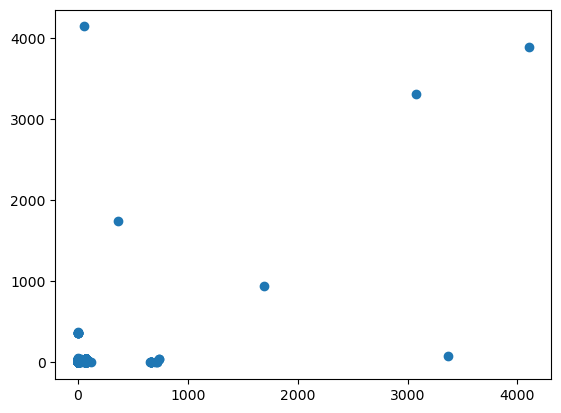

In [40]:
%%time
import matplotlib.pyplot as plt

sample = train_ddf.sample(frac=0.01)
plt.scatter(sample["abs_diff_longitude"], sample["abs_diff_latitude"])
# C'est un peu long mais on plot quand même 550 000 points...

Wow, looks like we have some strange values here: more than 1000° of distance... There's a problem somewhere.

<br>

<span style="color:#EB5E0B;font-style:italic">
- Just get rid of the extreme values, we should keep only values inside the city wall or so. Like with Pandas above...
</span>

In [41]:
%%time

train_ddf = train_ddf[(train_ddf.abs_diff_longitude < 5.0) & (train_ddf.abs_diff_latitude < 5.0)]

CPU times: user 4.87 ms, sys: 0 ns, total: 4.87 ms
Wall time: 4.66 ms


<span style="color:#EB5E0B;font-style:italic">

- you can do another plot like above with the filtered values if you like.
</span>

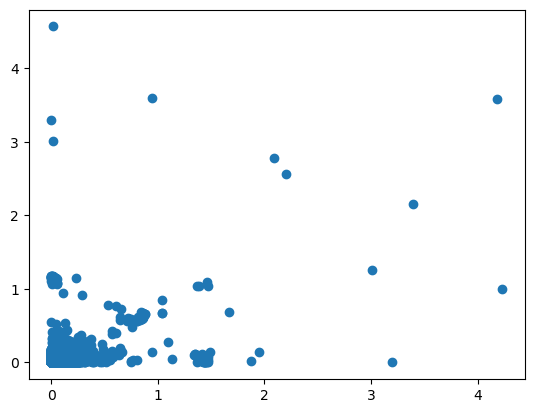

In [42]:
sample = train_ddf.sample(frac=0.01)
plt.scatter(sample["abs_diff_longitude"], sample["abs_diff_latitude"])
# C'est un peu long mais on plot quand même 550 000 points...

Ok, let's see some statistics on our Dataset. The describe() function inherited from Pandas compute a lot of statistics on a dataframe.

In [55]:
train_ddf.describe().compute()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
count,5.475582e+07,5.475582e+07,5.475582e+07,5.475582e+07,5.475582e+07,5.475582e+07,5.475582e+07,5.475582e+07
mean,1.133664e+01,-7.257282e+01,3.995285e+01,-7.257196e+01,3.995319e+01,1.685426e+00,2.251246e-02,2.110188e-02
std,2.079454e+01,1.095235e+01,7.041418e+00,1.095224e+01,7.041468e+00,1.326945e+00,3.855548e-02,2.903870e-02
min,-3.000000e+02,-3.440697e+03,-3.488080e+03,-3.440697e+03,-3.488080e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,-7.399201e+01,4.073514e+01,-7.399136e+01,4.073420e+01,1.000000e+00,5.830000e-03,6.606000e-03
50%,8.500000e+00,-7.398175e+01,4.075282e+01,-7.398010e+01,4.075333e+01,1.000000e+00,1.244600e-02,1.387800e-02
75%,1.250000e+01,-7.396703e+01,4.076724e+01,-7.396362e+01,4.076822e+01,2.000000e+00,2.370000e-02,2.691600e-02
max,9.396336e+04,3.456223e+03,3.378013e+03,3.456223e+03,3.378013e+03,2.080000e+02,4.989830e+00,4.991320e+00


<span style="color:green">Réponse :

- max(passenger_count) = 208 est surprenant pour des taxis
    
- max et min fare_amount sont bizarre : de -300€ à 94 000€

- même si on a supprimé les outliers en abs_diff, il reste des outliers en min/ max de pickup_lon/lat (3370°...)
</span>

<span style="color:#EB5E0B;font-style:italic">
    
- Do you think we could parallelize things better for any of our computation or data access (It's a trap), are our Worker correctly used, and why?.
</span>

<span style="color:green">
    
1. Le fait de faire un persist avant le préprocessing allourdit toutes les opérations derrières : durant le calcul des quantiles l'opération la plus longue est de faire un dropna à chaque lecture d'un nouveau chunk. Ainsi il faudrait refaire un persist une fois les données nettoyées
2. Il existe certainement un optimum sur la taille des chunks, pour un compromis vitesse de lecture % vitesse de traitement (c'est vrai avant le persist)
3. Chaque fonction ne nécéssite pas forcément la même taille de chunk : le calcul des quantiles trop paralélisé risque d'amener à plus d'incertitudes, alors que le min et max s'y prêtent très bien

Nos workers terminent à peu près en même temps, et travaillent tous donc ils sont plutôt bien utilisés.
</span>

<span style="color:#EB5E0B;font-style:italic">
    
### 2 points question (it might be a bit complex, consider skipping it at first, just go back to it later if you're stuck)

Some other questions to practice

- Can you see a correlation between the fare amount and the dropoff latitude? Answer by doing a dask dataframe computation.

First you'll need to round the dropoff latitude to have some sort of categories using Series.round() function.

Then, just group_by this new colon to have some answer (and don't forget to compute to get the results).
</span>

In [ ]:
## Answer needed here

OK, this don't give a lot of insights, but it looks like we've got some strange values somewhere!

<br>

<span style="color:#EB5E0B;font-style:italic">
- Let's just have a look of non extreme values, so probably some records at the middle of the results.
We need first to sort the resulting series by index before looking at the middle of it.
</span>

In [ ]:
## Answer needed there

OK, this is not really useful, but it's an exercise!

## Training a model in a distributed way

Let's begin with a linear model that we can distributed with Dask ML.

### Building our feature vectors

Here again define a method so that we can use it later for our test set evaluation.

<span style="color:#EB5E0B;font-style:italic">
    
- Just do the same as with the Pandas example by defining a get_input_matrix(df) function. But this time you'll generate a dask array (not numpy) using `to_dask_array(lengths=True)` method on the dataframe object instead of `np.column_stack` (look a bit a dask docs in order to find how to use this method). You should do a method that generate the X input features dask array, and also the same with y training results. You can do just one method that return both (return X, y). 
- You **don't** need to add a ones column, because we use real Machine Learning model which integrate Bias.
- It is a good idea to persist() arrays in memory in or after the call.
- This time, we'll add the feature 'passenger_count' in addition to the distance vectors, one more feature! So X must have 3 columns.
</span>

In [60]:
def get_dask_training_vectors(df):
    X = df[["abs_diff_longitude","abs_diff_latitude", "passenger_count"]].to_dask_array(lengths=True)
    y = df.fare_amount.to_dask_array(lengths=True)

    return X, y

Then we get the values, and display train_X to have some insights of its size and chunking scheme.

In [61]:
train_X, train_y = get_dask_training_vectors(train_ddf)
print(train_X.shape)
print(train_y.shape)

(54755818, 3)
(54755818,)


In [62]:
train_X = train_X.persist()
train_y = train_y.persist()

### Distributed training a Linear model

Be careful, this can take time, try first with few iterations (Use max_iter = 5 as a kwarg to LinearRegression constructor).

see https://ml.dask.org/glm.html  
and https://ml.dask.org/modules/generated/dask_ml.linear_model.LinearRegression.html#dask_ml.linear_model.LinearRegression

<span style="color:#EB5E0B;font-style:italic">
    
- Train a LinearRegression model from dask_ml.linear_model on our inputs
</span>


In [73]:
%%time
from dask_ml.linear_model import LinearRegression

lr  = LinearRegression(max_iter=10)
lr.fit(train_X, train_y)

CPU times: user 809 ms, sys: 72.4 ms, total: 881 ms
Wall time: 39.8 s


LinearRegression(max_iter=10)

## Evaluating our model


#### First we should load the test set.

In [67]:
test_ddf = dd.read_csv('gs://supaero/test.csv', storage_options={'token': 'anon'})
test_ddf

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
npartitions=1,,,,,,,,
,string,float64,string,float64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...


Adding our features to the test set and getting our feature array

In [69]:
add_travel_vector_features(test_ddf)
test_X, test_y = get_dask_training_vectors(test_ddf)
test_X

dask.array<values, shape=(535627, 3), dtype=float64, chunksize=(535627, 3), chunktype=numpy.ndarray>

We can use the score method inherited from Scikit learn, it gives some hints on the model performance (but our scoring board will be on RMSE). Even if for linear models, score if often low.

In [74]:
lr.score(test_X, test_y)

0.5410132322945843

In [71]:
lr.predict(test_X).compute()

array([10.57214321, 10.18232235,  9.30155872, ...,  7.60115594,
       12.40126963,  8.8927866 ])

#### Compute the RMSE

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation

In [75]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y.compute(), lr.predict(test_X).compute(), squared=False)

5.23380317207951

<span style="color:#EB5E0B;font-style:italic">
- What RMSE did you get? Compare it to the Pandas only computation.
</span>

<span style="color:green">
On obtient une RMSE de 5.23380317207951, qui ressemble énormément à pandas
</span>.


### Distributed XGboost (consider skipping it at first if you've trouble doing it)

Just use the documentation here https://xgboost.readthedocs.io/en/stable/tutorials/dask.html#overview to train a model on this dataset using xgboost.

<span style="color:#EB5E0B;font-style:italic">

- Just copy/paste the example (dtrain = ..., output = ...), and modify some input variables.
- Then make a prediction (but don't forget to use your test set, not as in the prediction = ... example from the Xgboost doc).
- Compute the mean square error on it.
</span>

In [78]:
from xgboost import dask as dxgb

dtrain = dxgb.DaskDMatrix(client, train_X, train_y)
dtest = dxgb.DaskDMatrix(client, test_X, test_y)

output = dxgb.train(
    client,
    {"verbosity": 2, "tree_method": "hist", "objective": "reg:squarederror"},
    dtrain,
    num_boost_round=4,
    evals=[(dtrain, "train")],
)

In [79]:
prediction = dxgb.predict(client, output, dtest)

In [80]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y.compute(), prediction.compute(), squared=False)

3.7668329567210037

# Use Dask to scale computation on Hyper Parameter Search

As seen above, Dask is well suited to distribute Data and learn a model on a big Data set. However, not all the models can be trained in parallel on sub chunks of Data. See https://scikit-learn.org/stable/computing/scaling_strategies.html for the compatible models of Scikit learn for example.

Dask can also be used to train several models in parallel on small datasets, this is what we'll try now.

We will just take a sample of the training set, and try to learn several models with different hyper parameters, and find the best one.

Dask Hyper parameter search : https://ml.dask.org/hyper-parameter-search.html.

First we'll take a small subset of the Data, 5% is a maximum if we want to avoir memory issues on our workers and have appropriate training times. You can try with less if the results are still good.

In [81]:
#Take a sample of the input data, get it as pandas dataframe
train_sample_ddf = train_ddf.sample(frac=0.05, random_state=270120)
# Get feature vectors out of it
train_sample_X, train_sample_y = get_dask_training_vectors(train_sample_ddf)

In order to optimize things, we can also change the type of the features to more appropriate and small types.

We also need to use Numpy arrays, so we'll gather the result from Dask to local variable.

In [82]:
train_sample_X = train_sample_X.astype('float32').compute()
train_sample_y = train_sample_y.astype('float32').compute()
train_sample_X

array([[6.2400e-03, 4.0630e-03, 3.0000e+00],
       [2.2138e-01, 3.5300e-03, 1.0000e+00],
       [7.6260e-03, 1.2543e-02, 3.0000e+00],
       ...,
       [3.2075e-02, 1.2116e-02, 2.0000e+00],
       [1.6215e-02, 3.0140e-02, 6.0000e+00],
       [1.4564e-02, 3.8220e-03, 2.0000e+00]], dtype=float32)

What size is our dataset ?

In [83]:
import sys
sys.getsizeof(train_sample_X)

32853632

About 32MB, this is still quite a big dataset for standard machine learning.

<span style="color:#EB5E0B;font-style:italic">

- Now, just use hyper parameter search Dask API to distribute the search. You can either use joblib integration with Sklearn or dask_ml directly. 

**Be careful: do not use model too long to train, and limit their complexity at first or the combinations of hyper parameters you'll use. Hint, start first with a simple LinearModel like SGDRegressor and not more than 10 iterations per model.**
</span>

So start with something like:

- RandomizedSearchCV https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html, with cv=2, n_iter=40, verbose=10
- With sklearn.linear_model.SGDRegressor with max_iter=10
- Use this parameter space:
```python
from scipy.stats import uniform, loguniform
param_space = {
    "average": [True, False],
    'penalty': ['l2', 'l1', 'elasticnet'],
    "alpha": loguniform(1e-5, 1e-1),
    "learning_rate": ["invscaling", "adaptive"],
    "power_t": uniform(0, 1),
}
```
- If you chose sklearn API, you want to import joblib, and use `with joblib.parallel_backend('dask'):` before fitting your model.
- If you chose dask_ml API, https://ml.dask.org/hyper-parameter-search.html#basic-use, you'll don't need the with syntax, but just the correct imports: from dask_ml.model_selection import RandomizedSearchCV

In [102]:
%%time
from dask_ml.model_selection import RandomizedSearchCV
from dask_ml.linear_model import SGDRegressor
from scipy.stats import uniform, loguniform

param_space = {
    "average": [True, False],
    'penalty': ['l2', 'l1', 'elasticnet'],
    "alpha": loguniform(1e-5, 1e-1),
    "learning_rate": ["invscaling", "adaptive"],
    "power_t": uniform(0, 1),
}

sgd = SGDRegressor()

search = RandomizedSearchCV(sgd, param_space, n_iter=10, random_state=0)
search.fit(train_X, train_y);
search.best_params_


ImportError: cannot import name 'SGDRegressor' from 'dask_ml.linear_model' (/srv/conda/envs/notebook/lib/python3.11/site-packages/dask_ml/linear_model/__init__.py)

In [101]:
search.score(test_X, test_y)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, search.predict(test_X), squared=False)

<span style="color:#EB5E0B;font-style:italic">

- So how does this result compare to the previous one we got with a distributed leaning with a linear model on all the dataset?
    
</span>

Le score est moins bon qu'avec un modèle linéaire sur tout le dataset.

<span style="color:#EB5E0B;font-style:italic">

- Try with https://ml.dask.org/modules/generated/dask_ml.model_selection.HyperbandSearchCV.html#dask_ml.model_selection.HyperbandSearchCV instead of RandomizedSearchCV.
    
You'd prefer to use dask_ml.model_selection.HyperbandSearchCV (instead of joblib). And just need to change n_iter to max_iter, and remove another arg.
    
</span>

In [97]:
%%time
from dask_ml.model_selection import HyperbandSearchCV
from sklearn.linear_model import SGDRegressor
from scipy.stats import uniform, loguniform

param_space = {
    "average": [True, False],
    'penalty': ['l2', 'l1', 'elasticnet'],
    "alpha": loguniform(1e-5, 1e-1),
    "learning_rate": ["invscaling", "adaptive"],
    "power_t": uniform(0, 1),
}

sgd = SGDRegressor()

search = HyperbandSearchCV(sgd, param_space, max_iter=20, random_state=0)
search.fit(train_X, train_y);
search.best_params_
search.best_score_


CPU times: user 1.16 s, sys: 63.7 ms, total: 1.22 s
Wall time: 34.7 s


0.5348443297493521

In [98]:
search.score(test_X, test_y)

0.5429278258395154

In [99]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, search.predict(test_X), squared=False)

5.222875757407681

<span style="color:#EB5E0B;font-style:italic">
    
- OK, Linear models are what they are, we'll try to do better with Random forest! https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
    
Return to RandomizedSearchCV for now.

Caution: use limited trees, small number of estimators < 10 and max_depth < 40 at first.

Use dask-ml directly and **not** joblib for this training.
</span>

For example:

```python
param_space = {
'n_estimators': range(4,10),
'max_depth': range(10,40),
}
```

In [ ]:
%%time
## Answer here

In [ ]:
search.score(test_X, test_y)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, search.predict(test_X), squared=False)

<span style="color:#EB5E0B;font-style:italic">
    
- Did you get better results with RandomForest? Do you know why?
</span>

In [ ]:
## Answer needed there

<span style="color:#EB5E0B;font-style:italic">
    
My best score was 3.5653424641520877, try to do better now!
</span>

<span style="color:#EB5E0B;font-style:italic">
    
# Extend this notebook
    
Try to do better! Some ideas:

- Add new features to the input Data using Dask Dataframes, or clean it better. Reapply the learning above with these new features. Do you get better results? Some suggestions for a better leaning:
  - Try to clean extremes or non realistic values you identified above in the training set.
  - Apply some normalisation or regularization or other feature transformation? See https://ml.dask.org/preprocessing.html.
  - Add some non linear features (square feature, for example square the travel vector)
  - Maybe the hour of the day, or the month, has some impact on fares? Try to add features. See https://matthewrocklin.com/blog/work/2017/01/12/dask-dataframes for some hints on how to do this.
  - Maybe try to find a way to use the start and drop off locations?
- Improve the model parameters or find a better one. Try using this time dask_ml HyperbandSearchCV. See https://ml.dask.org/hyper-parameter-search.html#basic-use. You can use it for example with https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor.
- Try one single RandomForestRegressor (with no HyperParameterSearch), but with big depth and estimators. This single model fitting should be distributed on dask with joblib (Random Forest is about training several decision trees).
- Try a bigger XGBoost model.

</span>


<span style="color:#EB5E0B;font-style:italic">
    
- Find some values (at least two) that still looks odd to you in the table above.
</span>